In [7]:
from utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


positives:  35
index:  [6167 6173 6179 6275 6281 6287 6293 6389 6395 6401 6407 6509 6515 6521
 8026 8027 8029 8031 8080 8082 8084 8086 8087 8088 8089 8090 8091 8092
 8093 8094 8096 8146 8147 8149 8151]
ious:  tensor([0.4450, 0.4864, 0.4123, 0.4242, 0.6031, 0.6659, 0.5543, 0.4242, 0.6031,
        0.6659, 0.5543, 0.4450, 0.4864, 0.4123, 0.4873, 0.4366, 0.5135, 0.4027,
        0.4335, 0.4667, 0.4027, 0.8042, 0.5561, 0.5423, 0.5423, 0.4027, 0.4027,
        0.5532, 0.4823, 0.5423, 0.4027, 0.4873, 0.4366, 0.5135, 0.4027])


tensor([0., 0., 0.,  ..., 0., 0., 0.])

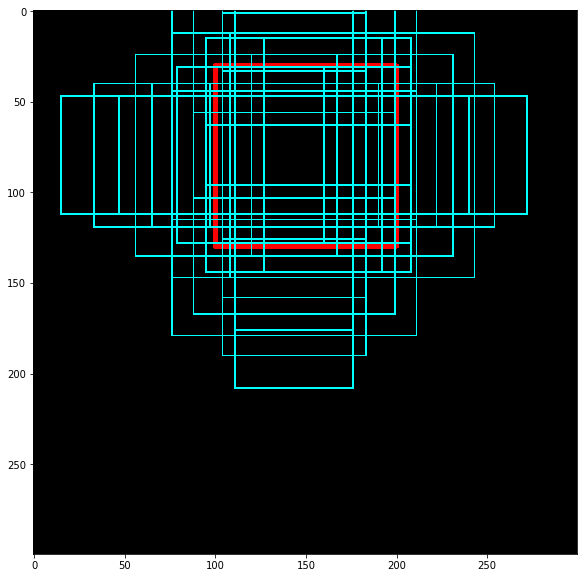

In [15]:
_, ious, mask = overlap(img_size, [100,30,200,130], thresh=0.40, sigmoid=True)
print("ious: ", ious.flatten())

# resolution in each prior
get_resolution(8254)
bb_intersection_over_union(corner_priors[9]*img_size, corner_priors[8]*img_size)

mask

In [20]:
mask[mask > 0]

tensor([0.0219, 0.2807, 0.0023, 0.0053, 1.0000, 1.0000, 0.9770, 0.0053, 1.0000,
        1.0000, 0.9770, 0.0219, 0.2807, 0.0023, 0.2933, 0.0124, 0.7175, 0.0012,
        0.0100, 0.0909, 0.0012, 1.0000, 0.9796, 0.9489, 0.9489, 0.0012, 0.0012,
        0.9752, 0.2275, 0.9489, 0.0012, 0.2933, 0.0124, 0.7175, 0.0012])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


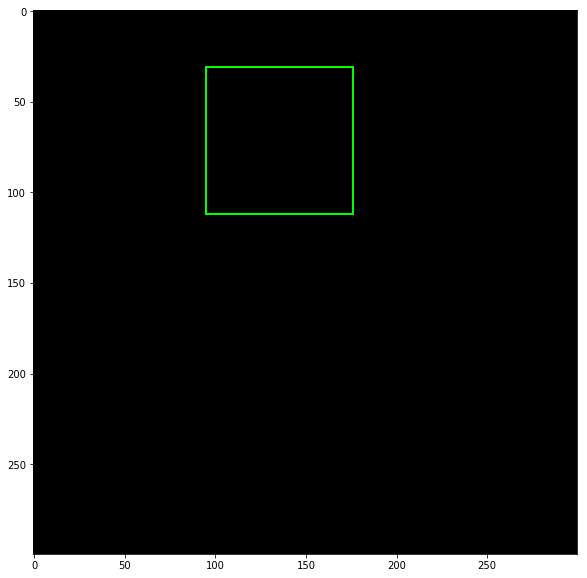

In [15]:
_ = bb_from_fourpoints(img_size, corner_priors[6281]*img_size)

In [6]:
from vision.utils.box_utils import assign_priors_for_count

real_boxes, real_labels, boxes, labels= assign_priors_for_count(torch.Tensor([[100,30,200,130]]), torch.Tensor([10]), corner_priors, iou_threshold=0.5)


TypeError: list indices must be integers or slices, not list

In [32]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys
sys.path.append("../")

from vision.ssd.ssd import MatchPrior
from vision.utils.box_utils import (assign_priors, center_form_to_corner_form, 
                                    corner_form_to_center_form, iou_of)
from vision.ssd.config.vgg_ssd_config import Config

anchors = [1,1,1]
rectangles = [[2],[2,3],[2,3],[2,3],[2],[2]]
num_anchors = [4,6,6,6,4,4]
vgg_config=[64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'C', 512, 512, 512, 'M', 512, 512, 512]

config = Config(anchors, rectangles, num_anchors, vgg_config)

img_size = 760

def line_wihte(image, max_, fm):
    """
    :: depict whcite lines in image. visualize grid
    """
    x = np.arange(0, max_, int(max_/fm))
    for i in range(len(x)):
        image = cv2.line(image, (x[i], 0),(x[i], max_),(100,100,100),2)
        image = cv2.line(image, (0, x[i]),(max_, x[i]),(100,100,100),2)
    return image


def bb_from_fourpoints(img_size, prior, color=(255,0,0), image=None):
    """
    view anrhor place in image , from only index of prior
    """
    if type(prior) == np.ndarray:
        prior = torch.from_numpy(prior)
    prior = prior.view(-1)
    if image is None:
        image = np.zeros((img_size, img_size, 3))
    image = cv2.rectangle(image, (prior[0], prior[1]),(prior[2], prior[3]), color, 3)
    plt.imshow(image)
    plt.show()
    return image

def bb_intersection_over_union(boxA, boxB):
    """
    get iou of two boxes
    boxA : [4]
    boxB : [4]
    """
    # determine the (x, y)-coordinates of the intersection rectangle
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = float(interArea) / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

def point_anchor_center(image, priors_coordinates_cornerform, radian, color=(255,0,0)):
    """
    point center point in featuremap
    """
    if priors_coordinates_cornerform.dim() != 2:
        priors_coordinates_cornerform.unsqueeze_(0)
        
    cx = (priors_coordinates_cornerform[0,2] + priors_coordinates_cornerform[0,0]) / 2
    cy = (priors_coordinates_cornerform[0,3] + priors_coordinates_cornerform[0,1]) / 2
    image = cv2.circle(image, (int(cx), int(cy)), radian, color, -1)
    return image

match_prioir = MatchPrior(config.priors, config.center_variance, config.size_variance, iou_threshold=0.5)
corner_priors = center_form_to_corner_form(config.priors.clone())
center_priors = config.priors.clone()  


In [33]:
# definition
fm = [38, 19, 10, 5, 3, 1]
anchor = [4, 6, 6, 6, 4, 4]
cuts = [0, 5776, 7942, 8542, 8692, 8728]

# tops = [38*4*10+52, 
#         38**2*4 + 19**2*6,  
#         38**2*4 + 19**2*6 + 10*4*6+18, 
#         38**2*4 + 19**2*6 + 10**2*6 + 5*2*6+12, 
#         38**2*4 + 19**2*6 + 10**2*6 + 5**2*6 + 3*1*4+4, 
#         ]

tops = [int((38**2*4)/2)+4*int(38/2), 
        38**2*4 + int((19**2*6)/2) - 3,  
        38**2*4 + 19**2*6 + 6*10*4+6*4, 
        38**2*4 + 19**2*6 + 10**2*6 + int((5**2*6)/2)-3, 
        38**2*4 + 19**2*6 + 10**2*6 + 5**2*6 + int((3**2*4)/2)-2, 
        ]


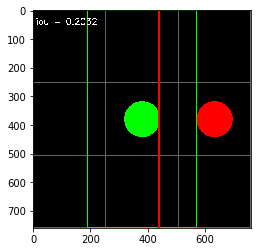

In [46]:

def anchors_various_in_one_grid(img_size, priors, f, top, anc, s):
    image = np.zeros((img_size, img_size, 3))
    image = line_wihte(image, max_=img_size, fm=f)
    point_anchor_center(image, priors[top], int(img_size/f/4), color=(0, 255, 0))
    for I in range(anc):       
        for i in [top+I]:
            image = cv2.rectangle(image, (priors[i,0], priors[i,1]), (priors[i,2], priors[i,3]), (0, 255, 0), s)
    plt.imshow(image/255)
    plt.imsave(f"next_grid/{f}_sample.png", image/255)

    
def anchors_with_next_grid(img_size, priors, f, top, anc, s):
    for I in range(anc):
        image = np.zeros((img_size,img_size,3))
        image = line_wihte(image, max_=img_size, fm=f)
        image = point_anchor_center(image, priors[top], int(img_size/f/4), color=(0, 255, 0))
        image = cv2.rectangle(image, (priors[top+I,0], priors[top+I,1]), 
                                  (priors[top+I,2], priors[top+I,3]), (0, 255, 0), s)
        image = point_anchor_center(image, priors[top+anc], int(img_size/f/4), color=(255, 0, 0))
        image = cv2.rectangle(image, (priors[top+anc+I,0]-s, priors[top+anc+I,1]-s), 
                                  (priors[top+anc+I,2]+s, priors[top+anc+I,3]+s), (255, 0, 0), s)
        iou = bb_intersection_over_union(priors[top+I], priors[top+anc+I])
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image, f"iou = {round(iou, 4)}", (10,50), font, 1, (255,255,255), 2, cv2.LINE_AA)
        plt.imshow(image/255)
        plt.imsave(f"next_grid/{f}_compare{I}.png", image/255)

        
def for_iou(prior):
    """
    [8732, 4] -> [8732, 1, 4]
    """
    if prior.dim() != 3:
        prior = prior.unsqueeze(0).permute(1, 0, 2)
    return prior    

def res_to_ind(res):
    print(res)
    return {38:0, 19:1, 10:2, 5:3, 3:4, 1:5}[res]
    
def anchors_with_next_scale(img_size, priors, fm, top):
    if type(priors) == np.ndarray:
        priors = torch.from_numpy(priors).clone()
    main_prior = priors[[top], :]
    scales_priors = devide_priors_into_each_scales(priors)
#     out = [ iou_of(for_iou(main_prior), for_iou(p)) for p in scales_priors ]
    out = [ iou_of(main_prior, p) for p in scales_priors ]
    top_k = [ torch.topk(x.view(-1), 3)[1] for x in out ]
    sub = [ torch.topk(x.view(-1), J)[0] for x, J in zip(out, [5,5,5,5,5,3]) ]
    top_k = [ x+start for x, start in zip(top_k, [0, 5776, 7942, 8542, 8692, 8728]) ]
    image = np.zeros((img_size, img_size, 3))
    image = line_wihte(image, img_size, fm)
    image = bb_from_fourpoints(img_size, priors[top], color=(0,255,0), image=image)
    for j in top_k[res_to_ind(fm)]:
        image = bb_from_fourpoints(img_size, priors[j], image=image)
        
#             image = point_anchor_center(image, priors[top], int(img_size/f/4), color=(0, 255, 0))
    return image, sub, top_k

def get_nearest_otherscales(priors, main_prior):
    """
    input:
        priors: all priors
        main_prior: one target prior
    """
    if type(priors) == torch.Tensor:
        priors = priors.numpy().copy()
    if type(main_prior) == torch.Tensor:
        main_prior = main_prior.numpy().copy()
    main_cx, main_cy = main_prior[2] - main_prior[0], main_prior[3] - main_prior[1]
    cx = (priors[:, 2]+priors[:, 0])/2
    cy = (priors[:, 3]+priors[:, 1])/2
    cx = cx.astype(np.int)
    cy = cy.astype(np.int)
    dc = np.stack((main_cx-cx, main_cy-cy)).transpose(1,0).reshape(-1, 2)
    print(dc.shape)
    distance = np.linalg.norm(dc, 2, axis=1)
    print(distance.shape)
    k_nearest = np.argmin(distance) 
    return k_nearest


def get_one_scale_priors(priors, fm):
    """
    input: [8732, 4]
    output: list of each scale prior
    """
    if fm == 38:
        out = priors[:5776, :]
    elif fm == 19:
        out = priors[5776:7942, :]
    elif fm == 10:
        out = priors[7942:8542, :]
    elif fm == 5:
        out = priors[8542:8692, :]
    elif fm == 3:
        out = priors[8692:8728, :]
    elif fm == 1:
        out = priors[8728:, :]
    return out


# [0, 5776, 7942, 8542, 8692, 8728]
def devide_priors_into_each_scales(priors):
    out = list()
    for i in [38, 19, 10, 5, 3, 1]:
        out.append(get_one_scale_priors(priors, i))
    return out

# --- main
s = 3 # 四角のかぶりずらし
for f, anc, top, cut in zip(fm, anchor, tops, cuts):
    """
    f: resoluton in feature map
    anc: num of anchors in onegrid
    top: to show anchors, in first plece index
    """ 
    anchors_various_in_one_grid(img_size, priors, f, top, anc, s)
    anchors_with_next_grid(img_size, priors, f, top, anc, s)
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


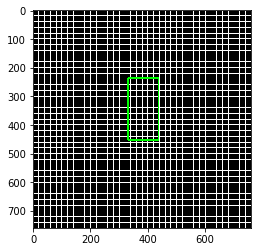

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


38


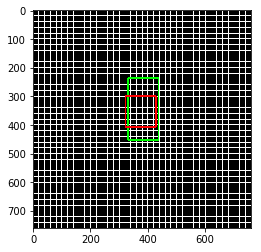

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


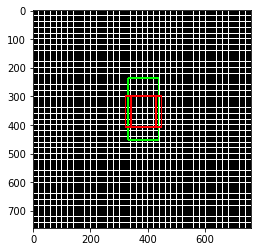

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


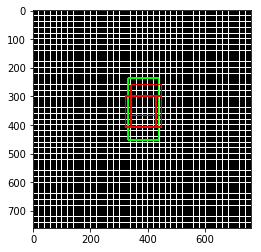

In [36]:
out = anchors_with_next_scale(img_size, priors, fm=38, top=6745)

In [52]:
out[1], out[2]

([tensor([0.4325, 0.4325, 0.4325, 0.4325, 0.4325]),
  tensor([1.0000, 0.6899, 0.6827, 0.6827, 0.6055]),
  tensor([0.2922, 0.2922, 0.2922, 0.2922, 0.2922]),
  tensor([0.1372, 0.1372, 0.1372, 0.1372, 0.1372]),
  tensor([0.0797, 0.0797, 0.0797, 0.0797, 0.0797]),
  tensor([0.0643, 0.0643, 0.0517])],
 [tensor([2657, 2661, 2357]),
  tensor([6745, 6747, 6859]),
  tensor([8206, 8212, 8211]),
  tensor([8619, 8589, 8649]),
  tensor([8714, 8706, 8710]),
  tensor([8730, 8731, 8728])])

In [65]:
bb_intersection_over_union(corner_priors[6745]*img_size, corner_priors[2357]*img_size)

0.4349827392383923

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


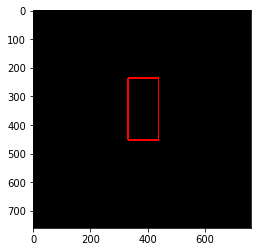

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


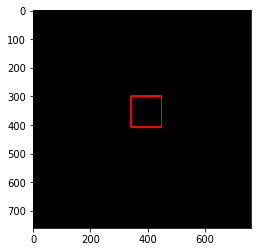

In [78]:
_ = bb_from_fourpoints(img_size, corner_priors[6745]*img_size)
_ = bb_from_fourpoints(img_size, corner_priors[2661]*img_size)